# DeepTesla@Celerative (DeepTesla dataset)
### Inspiración
* http://selfdrivingcars.mit.edu/deeptesla/
* https://github.com/naokishibuya/car-behavioral-cloning

### Objetivo
* Diseñar e implementar una CNN para predecir el ángulo de viraje a partir de imágenes tomadas por la cámara frontal del vehículo.
* Probar y evaluar el desempeño de la red en un simulador de piloto automático.

### Recursos
* Dataset: https://pan.baidu.com/s/1c2J2IFA#list/path=%2F%E5%85%B1%E4%BA%AB%2Fdeeptesla&parentPath=%2F%E5%85%B1%E4%BA%AB
* Documentación de Keras: https://keras.io/
* Documentación de OpenCV: http://opencv.org/
* Introduction to Udacity Self-Driving Car Simulator: https://medium.com/towards-data-science/introduction-to-udacity-self-driving-car-simulator-4d78198d301d

### Otros enlaces útiles
* Augmentation based DNN: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9


## Extracción de frames de los videos (Python 2)

In [ ]:
from __future__ import print_function

import numpy as np
import cv2, os

base_path = "J:/Datasets/deeptesla/"
validation_set = [9, 10]
frames_writed = 0

# Para cada video...
for video_id in xrange(1, 11):
    video_filename = "epoch%02d_front.mkv" % video_id
    video_path = os.path.join(base_path, video_filename)
    assert os.path.isfile(video_path)

    # Creamos el capturator
    cap = cv2.VideoCapture(video_path)
    print("Capturing from ", video_path)

    # Capturamos el primer frame
    ret, frame = cap.read()
    assert ret

    # Imprimimos su shape
    shape = frame.shape
    print(shape)

    # Mientras queden frames...
    while (ret):
        # Cortamos el frame 
        img = frame[int(shape[0]/2):shape[0], 0:shape[1]]
        # Llevamos la imagen al tamaño de entrada que utilizaremos en la CNN
        img = cv2.resize(img, (128, 64), interpolation=cv2.INTER_AREA)
        # Redimensionamos la imagen como un 4D array
        img = np.resize(img, (64, 128, 3))
        
        # Guardamos la imagen donde corresponda
        if video_id in validation_set:
            image_path = os.path.join(base_path, "validation/frame%05d.jpg" % frames_writed)
        else:
            image_path = os.path.join(base_path, "training/frame%05d.jpg" % frames_writed)
        cv2.imwrite(image_path, img)
        frames_writed += 1
        if frames_writed % 100 == 0:
            print("Writed %d images..." % frames_writed)

        # Display
        #cv2.imshow('frame', frame)
        #cv2.imshow('img', img)

        # User exit?
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Capturamos el siguiente frame
        ret, frame = cap.read()

    # Liberamos el capturator
    cap.release()

cv2.destroyAllWindows()


## Una primera mirada a los datos

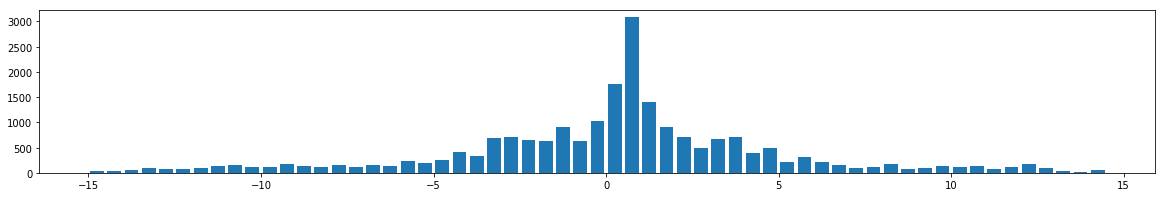

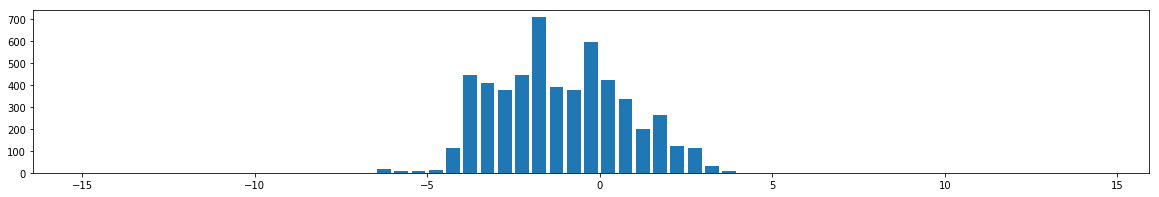

In [7]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

step = 0.5

y_train = np.genfromtxt("/mnt/j/Datasets/deeptesla/training.csv", delimiter = ',')
y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')

y_train_hist, bins = np.histogram(y_train, bins = np.arange(-15, 15, step))
y_test_hist, bins = np.histogram(y_test, bins = bins)

width = 0.8 * step
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, y_train_hist, align='center', width=width)
plt.show()
plt.bar(center, y_test_hist, align='center', width=width)
plt.show()


## Funciones y definiciones de utilidad

In [1]:
import numpy as np
import matplotlib.image as mpimg
import cv2, os

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 128, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

"""
Load RGB images from a file
"""
def load_image(image_file):
    return mpimg.imread(image_file.strip())

"""
Convert the image from RGB to YUV (This is what the NVIDIA model does)
"""
def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

"""
Randomly flipt the image left <-> right, and adjust the steering angle.
"""
def random_flip(image, steering_angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

"""
Randomly shift the image vertically and horizontally (translation).
"""
def random_translate(image, steering_angle, range_x, range_y):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.05
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

"""
Generates and adds random shadow
"""
def random_shadow(image):
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

"""
Randomly adjust brightness of the image.
"""
def random_brightness(image):
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

"""
Generate an augumented image and adjust steering angle.
(The steering angle is associated with the center image)
"""
def augment(image, steering_angle, range_x = 0, range_y = 10):
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

"""
Generate training image give image paths and associated steering angles
"""
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            steering_angle = steering_angles[index]
            image = load_image(image_paths[index])
            
            # augmentation
            if is_training and np.random.rand() < 0.5:
                image, steering_angle = augment(image, steering_angle)
            
            # add the image and steering angle to the batch
            images[i] = rgb2yuv(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

## Modelos de CNN

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

"""
Modelo flat
"""
def build_flat_model():
    model = Sequential() # 64x128 x 3
    model.add(Lambda(lambda x: x/127.5 - 1,
              input_shape = INPUT_SHAPE))
    
    model.add(Conv2D(8, (3, 3), padding = 'same',
                     activation = 'elu')) # 64x128 x 8

    model.add(Conv2D(16, (3, 3), padding = 'same',
                     activation = 'elu')) # 64x128 x 16
    model.add(MaxPooling2D(pool_size = (2, 2))) # 32x64 x 16
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(128, activation = 'elu'))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(loss = 'mean_squared_error',
                  optimizer = Adam(lr = 1.0e-4))
#                  optimizer = 'adadelta')
    
    return model

"""
Modelo estilo Nvidia
"""
def build_nv_model():
    model = Sequential() # 64x128x3
    model.add(Lambda(lambda x: x/127.5 - 1,
              input_shape = INPUT_SHAPE))
    
    model.add(Conv2D(24, (5, 5), activation = 'elu',
                     padding = 'same')) # 64x128 x 24
    model.add(MaxPooling2D(pool_size = (2, 2))) # 32x64 x 24

    model.add(Conv2D(36, (5, 5), activation = 'elu')) # 28x60 x 36
    model.add(MaxPooling2D(pool_size = (2, 2))) # 14x30 x 36

    model.add(Conv2D(48, (5, 5), activation = 'elu')) # 10x26 x 48
    model.add(MaxPooling2D(pool_size = (2, 2))) # 5x13 x 48

    model.add(Conv2D(64, (3, 3), activation = 'elu')) # 3x11 x 64

    model.add(Conv2D(64, (3, 3), activation = 'elu')) # 1x9 x 64
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.2))

    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation = 'elu'))

    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mean_squared_error',
                  optimizer = Adam(lr = 1.0e-4))
#                  optimizer = 'adadelta')

    return model

## Entrenamiento de la CNN

In [5]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

import glob

# Hiperparametros
epochs = 10
batch_size = 16

data_dir = "/mnt/j/Datasets/deeptesla/"
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'deeptesla-nv-model.h5'

# Datos!
X_train = glob.glob( os.path.join(data_dir, "training/*.jpg") )
X_train = np.sort(X_train)
X_test = glob.glob( os.path.join(data_dir, "validation/*.jpg") )
X_test = np.sort(X_test)
y_train = np.genfromtxt( os.path.join(data_dir, "training.csv") , delimiter = ',')
y_test = np.genfromtxt( os.path.join(data_dir, "validation.csv") , delimiter = ',')
y_train /= 25
y_test /= 25

#model = build_flat_model()
model = load_model('flat-model-009.h5')

checkpoint = ModelCheckpoint('flat-model-1{epoch:02d}.h5',
                             monitor = 'val_loss',
                             verbose = 1,
#                             save_best_only = True,
                             mode = 'auto')
    
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.,
                          patience = 10,
                          verbose = 1)

model.fit_generator(batch_generator(X_train, y_train, batch_size, True),
                    steps_per_epoch = 1000,
                    epochs = epochs,
#                    max_queue_size = 1,
                    validation_data = batch_generator(X_test, y_test, batch_size, False),
                    validation_steps = len(X_test) // batch_size,
                    callbacks = [checkpoint], #earlystop],
                    verbose = 2)


Epoch 1/10
Epoch 00000: saving model to flat-model-100.h5
379s - loss: 0.0171 - val_loss: 0.0071
Epoch 2/10
Epoch 00001: saving model to flat-model-101.h5
378s - loss: 0.0166 - val_loss: 0.0074
Epoch 3/10
Epoch 00002: saving model to flat-model-102.h5
400s - loss: 0.0163 - val_loss: 0.0070
Epoch 4/10
Epoch 00003: saving model to flat-model-103.h5
411s - loss: 0.0159 - val_loss: 0.0094
Epoch 5/10
Epoch 00004: saving model to flat-model-104.h5
416s - loss: 0.0154 - val_loss: 0.0068
Epoch 6/10
Epoch 00005: saving model to flat-model-105.h5
539s - loss: 0.0150 - val_loss: 0.0062
Epoch 7/10
Epoch 00006: saving model to flat-model-106.h5
532s - loss: 0.0153 - val_loss: 0.0077
Epoch 8/10
Epoch 00007: saving model to flat-model-107.h5
521s - loss: 0.0150 - val_loss: 0.0079
Epoch 9/10
Epoch 00008: saving model to flat-model-108.h5
386s - loss: 0.0153 - val_loss: 0.0066
Epoch 10/10
Epoch 00009: saving model to flat-model-109.h5
373s - loss: 0.0139 - val_loss: 0.0072


## Prueba del modelo

(5400,)
(5400, 1)


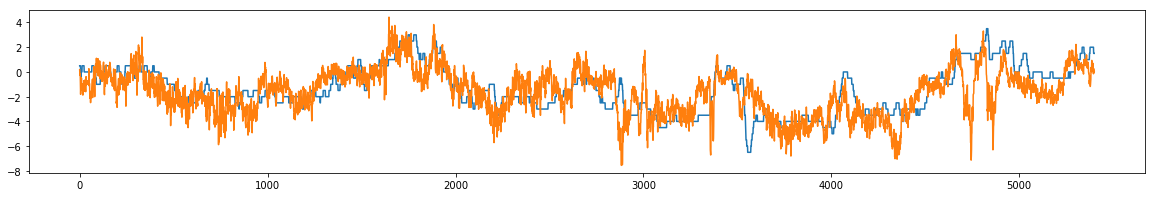

In [8]:
from __future__ import print_function

import keras
from keras import models

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

save_dir = os.path.join(os.getcwd(), 'saved_models')
model1_name = 'nv-model-204.h5'
model1_path = os.path.join(save_dir, model1_name)

# Cargar los modelos
model1 = models.load_model(model1_path)

x_test = []
filelist = glob.glob("/mnt/j/Datasets/deeptesla/validation/*.jpg")
for fname in filelist:
     x_test.append(rgb2yuv(np.array(Image.open(fname))))
x_test = np.array(x_test, dtype = 'float32')

y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')
print(y_test.shape)

plt.rcParams["figure.figsize"] = (20, 3)
plt.plot(y_test)
#plt.show()

# Generar predicciones
arr1 = model1.predict(x_test) * 25
print(arr1.shape)

plt.plot(arr1)
plt.show()
